In [8]:
! pip install -q kaggle

In [9]:
from google.colab import files

files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"swaradapathak","key":"0122cd4f102ccfde6a5847f9872440a2"}'}

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:08<00:00, 43.5MB/s]
100% 346M/346M [00:08<00:00, 41.1MB/s]


In [13]:
! unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [14]:
#Importing the required Libraries
import numpy as np
import pandas as pd

import os
import cv2
import tensorflow as tf

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#importing libraries that would be required for loading images and transfer learning
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

#importing optimizers
from tensorflow.keras.optimizers import RMSprop, Adam

import matplotlib.pyplot as plt

Importing the Dataset

Train

In [15]:
#Reading images
df_train = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_train/seg_train",
    labels='inferred', # labels from directory
    label_mode='int', #Encode labels as int [0,1...,6]
    class_names=None,
    color_mode='rgb',
    batch_size=32, #Default
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 14034 files belonging to 6 classes.


In [16]:
num_classes = len(df_train.class_names)
print("Number of classes:", num_classes)

Number of classes: 6


In [17]:
class_names = df_train.class_names
print(f"Class names: {class_names}")

Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Testing

In [18]:
df_test = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_test/seg_test",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3000 files belonging to 6 classes.


In [19]:
#For train data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

#for test data
test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(
    "/content/seg_train/seg_train",
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)


Found 14034 images belonging to 6 classes.


In [21]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [22]:
#define function to get labels
def get_Label(number):
    labels = { 0:'buildings', 1:'forest', 2:'glacier', 3:'mountain', 4:'sea', 5:'street'}
    return labels[number]

In [23]:
test_generator = test_datagen.flow_from_directory("/content/seg_test/seg_test",
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')

Found 3000 images belonging to 6 classes.


In [24]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [25]:
image_size=[224,224]
inception=InceptionV3(input_shape=image_size+[3],weights='imagenet',include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [26]:
#don't train existing weights
for layer in inception.layers:
    layer.trainable=False

In [27]:
#our layers
x=Flatten()(inception.output)

#num_classes is no. of classes i.e. 6
prediction=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=inception.input,outputs=prediction)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

Compile model

In [29]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
early_stopping=EarlyStopping(patience=4,verbose=1,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(factor=0.1,patience=3,verbose=1)

callbacks = [early_stopping, reduce_lr]

In [31]:
print(len(train_generator))
print(len(test_generator))

110
24


In [32]:
r = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator),
  callbacks=callbacks
)

Epoch 1/10
110/110 [==============================] - 221s 2s/step - loss: 1.4925 - accuracy: 0.7940 - val_loss: 0.7921 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 2/10
110/110 [==============================] - 195s 2s/step - loss: 0.7236 - accuracy: 0.8522 - val_loss: 0.5838 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 3/10
110/110 [==============================] - 199s 2s/step - loss: 0.7872 - accuracy: 0.8628 - val_loss: 0.8747 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 4/10
110/110 [==============================] - 195s 2s/step - loss: 0.7938 - accuracy: 0.8707 - val_loss: 1.0254 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 5/10
110/110 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.8718
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
110/110 [==============================] - 192s 2s/step - loss: 0.8103 - accuracy: 0.8718 - val_loss: 0.6820 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 6/10
110/110 [==============================] - 192s

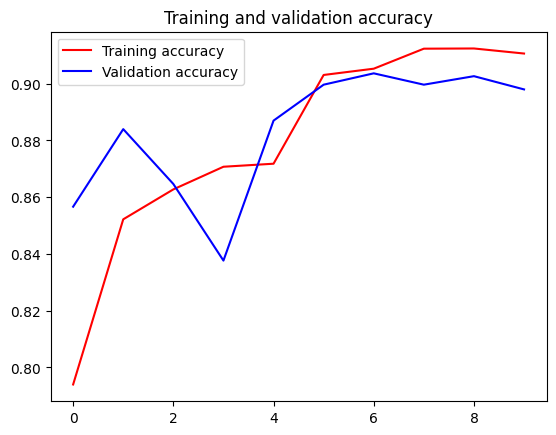

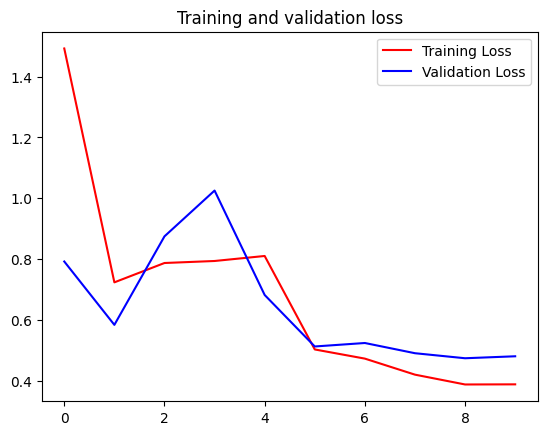

In [33]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
predictions = model.predict_generator(test_generator, steps = test_generator.n, verbose=1)

<ipython-input-34-f5f612ac21ad>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps = test_generator.n, verbose=1)


  24/3000 [..............................] - ETA: 15:15

3000/3000 [==============================] - 9s 2ms/step


In [35]:
predictions

array([[8.27760712e-14, 7.72364594e-18, 5.53771019e-01, 9.13404569e-04,
        4.45315599e-01, 1.60970959e-09],
       [8.81783400e-17, 4.65553724e-12, 4.60702040e-06, 2.68791018e-06,
        9.99992728e-01, 2.20016554e-15],
       [6.50962522e-18, 1.35798651e-16, 1.08331496e-13, 2.61868131e-12,
        1.00000000e+00, 3.85137278e-17],
       ...,
       [9.99510527e-01, 8.48779195e-22, 3.37617781e-11, 2.08922811e-14,
        2.84379399e-13, 4.89493075e-04],
       [4.70503350e-16, 4.20500630e-14, 9.99309659e-01, 6.90319052e-04,
        3.32655726e-16, 1.15983647e-19],
       [4.11414253e-19, 2.23215061e-18, 5.79229500e-08, 3.17776951e-11,
        1.00000000e+00, 1.12475980e-14]], dtype=float32)

In [36]:
# find the class with the largest predicted probability.
result = np.argmax(predictions,axis=1)
result

array([2, 4, 4, ..., 0, 2, 4])